✅ Using CuPy with GPU support


C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\2488431918.py:458: RuntimeWarning: invalid value encountered in divide
  aux_m= np.where(den > eps, rm_pos / den, 0.0)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\2488431918.py:459: RuntimeWarning: invalid value encountered in divide
  alpha_m3 = np.where(abs(rm_pos/den-1)<0.1, rm_pos , aux_m)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\2488431918.py:461: RuntimeWarning: invalid value encountered in divide
  aux_n= np.where(den > eps, rn_pos / den, 0.0)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\2488431918.py:462: RuntimeWarning: invalid value encountered in divide
  alpha_n3 = np.where(abs(rn_pos/den-1)<0.1, rn_pos , aux_n)


KeyboardInterrupt: 

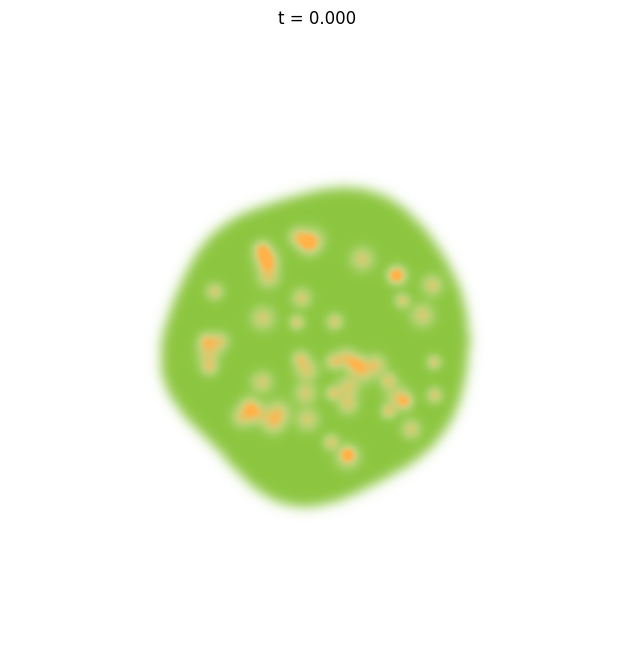

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

import matplotlib as mpl
from matplotlib.colors import Normalize, LinearSegmentedColormap

ffmpeg_path = os.path.abspath("ffmpeg/bin/ffmpeg.exe")
mpl.rcParams["animation.ffmpeg_path"] = ffmpeg_path

# ======================================
#  GPU (CuPy) or CPU (NumPy)
# ======================================
try:
    import cupy as cp
    from cupy.fft import fft2, ifft2, fftfreq
    GPU = True
    print("✅ Using CuPy with GPU support")
except Exception:
    import numpy as cp
    from numpy.fft import fft2, ifft2, fftfreq
    GPU = False
    print("⚠️ There isn't GPU/CUDA available, using NumPy with CPU")

seed = 3553
np.random.seed(seed)

if GPU:
    cp.random.seed(seed)


def sync():
    if GPU:
        import cupy as _cp
        _cp.cuda.Device().synchronize()

def to_cpu(a):
    if GPU:
        import cupy as _cp
        return _cp.asnumpy(a)
    return a



Overexpression = True  # Set to True for overexpression condition, False for WT condition

# ======================================
# GLOBAL ADIMENSIONAL PARAMETERS
# ======================================
Nx = 128 * 4*2
Ny = 128 * 4*2
Lx = 10.0 * 2
Ly = 10.0 * 2
dx = Lx / Nx
dy = Ly / Ny

# ---- Adimensional values ----
if Overexpression:
    C_scale = 10
    h_over  = 4
else:
    C_scale = 1
    h_over  = 1

chi_rho      = 1000
nc         = 1
chi_h     = 100*C_scale
nch        = 1
B_h        = 3 * h_over
A_hh_nd    = 0  
D_c  = 1
D_h  = 1e-2
Gamma_rho   = 5
Gamma_h    = 50* h_over/C_scale
Lambda_nd  = 10000
D_rho_m = 1e-2 
D_rho_n = 1e-2 
M_rho   = 1.0
M_h     = 50 
M_0     = 100 
Kc = 0.001

# ======================================
# Time + CFL adaptative
# ======================================
dt0 = 1e-5
nt = 100000
t_end = nt * dt0

n_frames = 100
frame_dt = t_end / n_frames

CFL_TARGET = 0.15
CFL_SAFETY = 0.9
DT_MIN = 1e-7
DT_MAX = 1e-4
DT_GROW_MAX = 1.25
DT_SHRINK_MIN = 0.5

# Colormaps overlay
green_hex = "#8cc63f"
orange_hex = "#ffb349"

green_cmap = LinearSegmentedColormap.from_list("custom_green", [green_hex, green_hex])
orange_cmap = LinearSegmentedColormap.from_list("custom_orange", [orange_hex, orange_hex])

# ======================================
# Fourier frequencies 
# ======================================
def fftfreq_1d_gpu(n, L):
    return 2.0 * cp.pi * fftfreq(n, d=L/n)

kx = fftfreq_1d_gpu(Nx, Lx).astype(cp.float32)
ky = fftfreq_1d_gpu(Ny, Ly).astype(cp.float32)
KX = cp.tile(kx[cp.newaxis, :], (Ny, 1))
KY = cp.tile(ky[:, cp.newaxis], (1, Nx))
K2 = (KX**2 + KY**2).astype(cp.float32)

# ======================================
# Grid and field initialitation
# ======================================
x = cp.linspace(0.0, Lx, Nx, endpoint=False, dtype=cp.float32)
y = cp.linspace(0.0, Ly, Ny, endpoint=False, dtype=cp.float32)

rho_m = cp.zeros((Ny, Nx), dtype=cp.float32)
rho_n = cp.zeros((Ny, Nx), dtype=cp.float32)
h     = cp.zeros((Ny, Nx), dtype=cp.float32)
c     = cp.full((Ny, Nx), 0.0, dtype=cp.float32)


# ======================================
# Initial condition
# ======================================
x0, y0 = Lx / 2.0, Ly / 2.0
rho0 = 1

surface_noise_amp = 0.08
surface_noise_amp_plume = 0.10
num_modes = 6

R_bio = 1.5
R_core = 0.2
R_plume = 0.5

X, Y = cp.meshgrid(x, y)
dx_ = X - x0
dy_ = Y - y0
r = cp.sqrt(dx_**2 + dy_**2)
theta = cp.arctan2(dy_, dx_)

phases = (2 * np.pi * np.random.rand(num_modes)).astype(np.float32)


def make_angular_noise(theta, phases):
    noise = cp.zeros_like(theta, dtype=cp.float32)
    for k, phase in enumerate(phases, start=1):
        noise += cp.cos(k * theta + cp.asarray(phase))
    noise /= (cp.max(cp.abs(noise)) + 1e-12)
    return noise

def gaussian_filter_fft(field, sigma):
    fhat = fft2(field)
    gaussian = cp.exp(-0.5 * sigma**2 * K2)
    fhat *= gaussian
    return ifft2(fhat).real.astype(cp.float32)

noise_theta_core = make_angular_noise(theta, phases)
noise_theta_plume = make_angular_noise(theta, phases)

R_bio_pert = R_bio * (1 + surface_noise_amp * noise_theta_core)
mask_core = r <= R_bio_pert

R_plume_pert = R_plume * (1 + surface_noise_amp_plume * noise_theta_plume)
mask_plume_circle = r <= R_plume_pert

# --- plume core (cone) ---
L_plume = R_plume*2/3
base_w  = R_core
tip_pow = 1

u = X - x0 - R_plume*0.9
v = Y - y0

s = u / (L_plume + 1e-12)
s = cp.clip(s, 0.0, 1.0)

w = base_w * (1.0 - s)**tip_pow
w = w * (1.0 + surface_noise_amp_plume * 0.5 * noise_theta_plume)
w = cp.maximum(w, 0.0)

mask_plume_core = (u >= 0.0) & (u <= L_plume) & (cp.abs(v) <= w)
mask_plume = mask_plume_circle | mask_plume_core

rho_m[:] = 0.0
rho_n[:] = 0.0
mask_nm = mask_core & (~mask_plume)
mask_m  = mask_plume

rho_n[mask_nm] = rho0
rho_m[mask_m]  = rho0

# ---- gaussian filter ----
rho_m[:] = 0.0
rho_n[:] = 0.0
mask_nm = mask_core 
rho_n[mask_nm] = rho0

sigma_filter = 3.0 * dx   # ~ 1–3 dx
rho_n = gaussian_filter_fft(rho_n, sigma_filter)

if not Overexpression:

    mask_m = mask_plume
    rho_n[mask_m] = 0
    rho_m[mask_m] = rho0

else:

    num_points = 50
    perp=0.6
    for _ in range(num_points):
        spot_sigma = cp.random.uniform(0.08, 0.05)
        rr = cp.sqrt(cp.random.uniform(R_core*R_core, 0.85*0.85*R_bio*R_bio))
        tt = 2 * cp.pi * cp.random.rand()
        px = x0 + rr * cp.cos(tt)
        py = y0 + rr * cp.sin(tt)

        dist2 = (X - px)**2 + (Y - py)**2
        bump = rho0 * cp.exp(-dist2 / (2 * spot_sigma**2))
        rho_m += perp * bump
        rho_n -= perp * bump

rho_n = cp.maximum(rho_n, 0.0).astype(cp.float32)
rho_m = cp.minimum(rho_m, rho0).astype(cp.float32)
rho_n = cp.minimum(rho_n, rho0).astype(cp.float32)

# ======================================
# Operators (FD for grad/div + FFT for laplacian)
# ======================================
def grad_fd_gpu(f):
    fx = (cp.roll(f, -1, axis=1) - cp.roll(f, 1, axis=1)) / (2.0 * dx)
    fy = (cp.roll(f, -1, axis=0) - cp.roll(f, 1, axis=0)) / (2.0 * dy)
    return fx.astype(cp.float32), fy.astype(cp.float32)

def div_fd_gpu(Jx, Jy):
    dJx = (cp.roll(Jx, -1, axis=1) - cp.roll(Jx, 1, axis=1)) / (2.0 * dx)
    dJy = (cp.roll(Jy, -1, axis=0) - cp.roll(Jy, 1, axis=0)) / (2.0 * dy)
    return (dJx + dJy).astype(cp.float32)

def laplacian_fft_gpu(f):
    f_hat = fft2(f)
    lap_hat = -K2 * f_hat
    lap = ifft2(lap_hat).real.astype(cp.float32)
    return lap

# ======================================
# Mobility/Viscosity
# ======================================
def compute_mu_M_gpu(rho_m, rho_n, h):
    rho_tot = rho_m + rho_n
    term_rho = M_rho * rho_tot 
    term_h   = M_h   * h 
    term_b = M_0 * cp.maximum(0, 1-rho_tot-h)
    M = term_h + term_rho + term_b
    mu  = 1.0 / M
    return mu.astype(cp.float32), M.astype(cp.float32)

# ======================================
# Jacobi pressure
# ======================================
def jacobi_pressure_gpu(M, S, p_init, dx, dy, max_iter, tol):
    dx2 = dx * dx
    dy2 = dy * dy
    p = p_init.copy()

    Me = 0.5 * (M + cp.roll(M, -1, axis=1))
    Mw = 0.5 * (M + cp.roll(M,  1, axis=1))
    Mn = 0.5 * (M + cp.roll(M, -1, axis=0))
    Ms = 0.5 * (M + cp.roll(M,  1, axis=0))

    A_diag = (Me + Mw) / dx2 + (Mn + Ms) / dy2
    A_diag = cp.maximum(A_diag, 1e-12).astype(cp.float32)

    for _ in range(max_iter):
        p_e = cp.roll(p, -1, axis=1)
        p_w = cp.roll(p,  1, axis=1)
        p_n = cp.roll(p, -1, axis=0)
        p_s = cp.roll(p,  1, axis=0)

        rhs = (Me * p_e + Mw * p_w) / dx2 + (Mn * p_n + Ms * p_s) / dy2 - S
        p_new = (rhs / A_diag).astype(cp.float32)

        diff = cp.max(cp.abs(p_new - p))
        p = p_new
        if float(diff) < tol:
            break

    return p

def solve_pressure_gpu(growth_m, growth_n, prod_h, M, tol=1e-5, max_iter=500, p_init=None):
    Q_tot = prod_h + (growth_m + growth_n)
    S = -Q_tot
    S = S - cp.mean(S)

    p0 = cp.zeros_like(M, dtype=cp.float32) if p_init is None else p_init.astype(cp.float32)
    p = jacobi_pressure_gpu(M.astype(cp.float32), S.astype(cp.float32), p0, dx, dy, max_iter, tol)
    p -= cp.mean(p)
    return p

# ======================================
# Step with dt variable + CFL returned
# ======================================
def step_gpu(rho_m, rho_n, h, c, p_old, dt):
    rho_tot = rho_m + rho_n

    phi_c = (chi_rho * c)**nc / (1.0 + (chi_rho * c)**nc)
    growth_m = (rho_m * phi_c).astype(cp.float32)
    growth_n = (rho_n * phi_c).astype(cp.float32)

    psi_c = (chi_h * c)**nch / (1.0 + (chi_h * c)**nch)
    prod_h = (B_h * psi_c * rho_m - A_hh_nd * h).astype(cp.float32)

    mu, M = compute_mu_M_gpu(rho_m, rho_n, h)
    p = solve_pressure_gpu(growth_m, growth_n, prod_h, M, p_init=p_old)

    # gradient (FD)
    dpdx, dpdy = grad_fd_gpu(p)
    u_x = (-M * dpdx).astype(cp.float32)
    u_y = (-M * dpdy).astype(cp.float32)

    cfl_field = (cp.abs(u_x) * dt / dx) + (cp.abs(u_y) * dt / dy)
    cfl_max = float(cp.max(cfl_field))
    umax = float(cp.max(cp.sqrt(u_x*u_x + u_y*u_y)))

    # Advection (J = rho * u)
    Jmx = (rho_m * u_x).astype(cp.float32)
    Jmy = (rho_m * u_y).astype(cp.float32)
    Jnx = (rho_n * u_x).astype(cp.float32)
    Jny = (rho_n * u_y).astype(cp.float32)
    Jhx = (h * u_x).astype(cp.float32)
    Jhy = (h * u_y).astype(cp.float32)

    # divergence (FD)
    divJ_m = div_fd_gpu(Jmx, Jmy)
    divJ_n = div_fd_gpu(Jnx, Jny)
    divJ_h = div_fd_gpu(Jhx, Jhy)

    # Laplacian (FFT) 
    lap_h = laplacian_fft_gpu(h)
    lap_rho_m = laplacian_fft_gpu(rho_m)
    lap_rho_n = laplacian_fft_gpu(rho_n)

    # Cell and hydrogel densities dynamics
    rho_m_new = rho_m + dt * (-divJ_m + growth_m + D_rho_m * lap_rho_m)
    rho_n_new = rho_n + dt * (-divJ_n + growth_n + D_rho_n * lap_rho_n)
    rho_m_new = cp.maximum(rho_m_new, 0.0).astype(cp.float32)
    rho_n_new = cp.maximum(rho_n_new, 0.0).astype(cp.float32)

    h_new = h + dt * (-divJ_h + prod_h + D_h * lap_h)
    h_new = cp.maximum(h_new, 0.0).astype(cp.float32)

    # Nutrient dynamics
    c_hat = fft2(c)
    c_hat *= cp.exp(-K2 * D_c * dt)
    c_diff = ifft2(c_hat).real.astype(cp.float32)

    c_new = c_diff + dt * (
        -Gamma_rho * phi_c * rho_tot
        -Gamma_h  * psi_c * rho_m
        +Lambda_nd * Kc/(rho_tot + h + Kc) * (1.0 - c)
    )
    c_new = cp.maximum(c_new, 0.0).astype(cp.float32)

    return rho_m_new, rho_n_new, h_new, c_new, p, mu, cfl_max, umax

def check_blowup(arrays, max_abs=1e6):
    for name, a in arrays.items():
        if bool(cp.any(~cp.isfinite(a))):
            return True, f"{name} has NaN/inf"
        if float(cp.max(cp.abs(a))) > max_abs:
            return True, f"{name} has exceeded the maximum allowed value of {max_abs}"
    return False, ""

# ======================================
# Simultaion + movies
# ======================================
def run_and_movie_gpu(
    filename=f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}.mp4",
):
    
    if Overexpression:
        panel_dir = f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}/panel"
        panel_times = [0.0, 0.15, 0.3, 0.45]   
    else:   
        panel_dir = f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}/panel"
        panel_times = [0.0, 0.3, 0.6, 0.9]   
    os.makedirs(panel_dir, exist_ok=True)

    
    panel_saved = [False]*len(panel_times)

    os.makedirs(os.path.dirname(filename), exist_ok=True)


    rho_m_curr = rho_m.copy()
    rho_n_curr = rho_n.copy()
    h_curr     = h.copy()
    c_curr     = c.copy()

    # initialitation of p
    rho_tot0 = rho_m_curr + rho_n_curr
    phi_c0 = (chi_rho * c_curr)**nc / (1.0 + (chi_rho * c_curr)**nc)
    growth_m0 = (rho_m_curr * phi_c0).astype(cp.float32)
    growth_n0 = (rho_n_curr * phi_c0).astype(cp.float32)
    psi_c0 = (chi_h * c_curr)**nch / (1.0 + (chi_h * c_curr)**nch)
    prod_h0 = (B_h * psi_c0 * rho_m_curr - A_hh_nd * h_curr).astype(cp.float32)

    mu0, M0 = compute_mu_M_gpu(rho_m_curr, rho_n_curr, h_curr)
    p_curr = solve_pressure_gpu(growth_m0, growth_n0, prod_h0, M0, p_init=None)
    mu_curr = mu0

    # =======================
    # FIGURE
    # =======================

    sync()
    rho_m_cpu = to_cpu(rho_m_curr)
    rho_n_cpu = to_cpu(rho_n_curr)
    h_cpu     = to_cpu(h_curr)
    c_cpu     = to_cpu(c_curr)
    p_cpu     = to_cpu(p_curr)
    mu_cpu    = to_cpu(mu_curr)
    rho_tot_cpu = rho_m_cpu + rho_n_cpu

    rho_tot_max  = rho_tot_cpu.max()
    rho_m_max    = rho_m_cpu.max()
    rho_n_max    = rho_n_cpu.max()
    c_max        = c_cpu.max()
    h_max_global = h_cpu.max()
    p_min, p_max = p_cpu.min(), p_cpu.max()
    mu_min_frame, mu_max_frame = mu_cpu.min(), mu_cpu.max()


    fig, ax = plt.subplots(1, 1, figsize=(8, 6.5), constrained_layout=True)

    norm_fixed01 = Normalize(vmin=0.0, vmax=1.0)
    eps = 1e-12

    rho_m_01 = np.clip(rho_m_cpu, 0.0, 1.0)
    rho_n_01 = np.clip(rho_n_cpu, 0.0, 1.0)

    rm_pos = np.maximum(rho_m_cpu, 0.0)
    rn_pos = np.maximum(rho_n_cpu, 0.0)
    den = rm_pos + rn_pos


    aux_m= np.where(den > eps, rm_pos / den, 0.0)
    alpha_m3 = np.where(abs(rm_pos/den-1)<0.1, rm_pos , aux_m)

    aux_n= np.where(den > eps, rn_pos / den, 0.0)
    alpha_n3 = np.where(abs(rn_pos/den-1)<0.1, rn_pos , aux_n)


    im_m = ax.imshow(
        rho_m_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=orange_cmap, norm=norm_fixed01, alpha=alpha_m3
    )
    im_n = ax.imshow(
        rho_n_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=green_cmap , norm=norm_fixed01, alpha=alpha_n3
    )

    ax.set_ylim(7, 13)
    ax.set_xlim(7, 13)


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.axis("off")


    # cbar_m3 = fig3.colorbar(im_m3, ax=ax3, fraction=0.046, pad=0.04)
    # cbar_m3.set_label("ρₘ (motile) [0..1]")
    # cbar_n3 = fig3.colorbar(im_n3, ax=ax3, fraction=0.046, pad=0.12)
    # cbar_n3.set_label("ρₙ (non motile) [0..1]")

    writer  = FFMpegWriter(fps=10, bitrate=1800)

    t = 0.0
    dt = dt0
    step_count = 0
    next_frame_t = 0.0
    frame_idx = 0

    L_char = R_bio


    with writer.saving(fig, filename, dpi=150):

        fig.suptitle(f"t = {t:.3f}")

        writer.grab_frame()

        frame_idx += 1
        next_frame_t += frame_dt

        while (t < t_end and frame_idx <= n_frames) and (not all(panel_saved)):
            rho_m_curr, rho_n_curr, h_curr, c_curr, p_curr, mu_curr, cfl_max, umax = step_gpu(
                rho_m_curr, rho_n_curr, h_curr, c_curr, p_curr, dt
            )
            step_count += 1
            t += dt

            blow, reason = check_blowup({
                "rho_m": rho_m_curr,
                "rho_n": rho_n_curr,
                "h":     h_curr,
                "c":     c_curr,
                "p":     p_curr,
                "mu":    mu_curr,
            }, max_abs=1e6)
            if blow:
                sync()
                print(f"[STOP] blow-up in step={step_count}, t={t:.3f} → {reason}")
                break

            # dt 
            if cfl_max > 0.0:
                dt_cfl = CFL_SAFETY * CFL_TARGET * dt / (cfl_max + 1e-30)
                dt_cfl = min(dt_cfl, dt * DT_GROW_MAX)
                dt_cfl = max(dt_cfl, dt * DT_SHRINK_MIN)
                dt = float(np.clip(dt_cfl, DT_MIN, DT_MAX))

            if t >= next_frame_t:
                sync()
                rho_m_cpu = to_cpu(rho_m_curr)
                rho_n_cpu = to_cpu(rho_n_curr)
                h_cpu     = to_cpu(h_curr)
                c_cpu     = to_cpu(c_curr)
                p_cpu     = to_cpu(p_curr)
                mu_cpu    = to_cpu(mu_curr)
                rho_tot_cpu = rho_m_cpu + rho_n_cpu

                rho_tot_max  = max(rho_tot_max,  rho_tot_cpu.max())
                rho_m_max    = max(rho_m_max,    rho_m_cpu.max())
                rho_n_max    = max(rho_n_max,    rho_n_cpu.max())
                c_max        = max(c_max,        c_cpu.max())
                h_max_global = max(h_max_global, h_cpu.max())
                p_min        = min(p_min,        p_cpu.min())
                p_max        = max(p_max,        p_cpu.max())
                mu_min_frame = min(mu_min_frame, mu_cpu.min())
                mu_max_frame = max(mu_max_frame, mu_cpu.max())

                eps = 1e-2
                rho_m_01 = np.clip(rho_m_cpu, 0.0, 1.0)
                rho_n_01 = np.clip(rho_n_cpu, 0.0, 1.0)

                rm_pos = np.maximum(rho_m_cpu, 0.0)
                rn_pos = np.maximum(rho_n_cpu, 0.0)
                den = rm_pos + rn_pos

                rm_pos= np.where(rm_pos > eps, rm_pos, 0.0)
                alpha_m3 = np.where(den < 1, rm_pos , rm_pos / den)
                alpha_m3= np.clip(alpha_m3, 0, 1)

                rn_pos= np.where(rn_pos > eps, rn_pos, 0.0)
                alpha_n3 = np.where(den < 1, rn_pos , rn_pos / den)
                alpha_n3= np.clip(alpha_n3, 0, 1)


                im_m.set_data(rho_m_01); im_m.set_alpha(alpha_m3)
                im_n.set_data(rho_n_01); im_n.set_alpha(alpha_n3)


                fig.suptitle(f"t = {t:.2f}")
                fig.canvas.draw()
                writer.grab_frame()


                mu_mean = float(cp.mean(mu_curr))
                Pe_rho_m = umax * L_char / (D_rho_m + 1e-30)
                Pe_rho_n = umax * L_char / (D_rho_n + 1e-30)
                Pe_h     = umax * L_char / (D_h     + 1e-30)
                Pe_c     = umax * L_char / (D_c     + 1e-30)
                Re_eff   = umax * L_char / (mu_mean       + 1e-30)
                for i, tp in enumerate(panel_times):
                    if (t >= tp) and (not panel_saved[i]):


                        fig_snap, ax_snap = plt.subplots(figsize=(4,4))

                        ax_snap.imshow(rho_m_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=orange_cmap,
                                    alpha=alpha_m3)

                        ax_snap.imshow(rho_n_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_n3)

                        ax_snap.set_xlim(7,13)
                        ax_snap.set_ylim(7,13)
                        ax_snap.set_xticks([])
                        ax_snap.set_yticks([])
                        ax_snap.axis("off")
                        ax_snap.set_aspect("equal")

                        fname = f"{panel_dir}/snap_{i}.png"
                        fig_snap.savefig(fname, dpi=200)
                        plt.close(fig_snap)

                        print(f"📸 snapshot saved to {fname}")
                        panel_saved[i] = True


                print(
                    f"[{'GPU' if GPU else 'CPU'}] step={step_count}  t={t:.2f}"
                    # f"[{'GPU' if GPU else 'CPU'}] step={step_count}  t={t:.3f}  dt={dt:.2e}  "
                    # f"max(rho_n)={float(cp.max(rho_n_curr)):.3f}  "
                    # f"max(rho_m)={float(cp.max(rho_m_curr)):.3f}  "
                    # f"max(h)={float(cp.max(h_curr)):.3f}  "
                    # f"max(p)={float(cp.max(p_curr)):.3f}  "
                    # f"mu_min={float(cp.min(mu_curr)):.3f}  "
                    # f"mu_max={float(cp.max(mu_curr)):.3f}  "
                    # f"CFL_max={cfl_max:.3e}  umax={umax:.3e}  "
                    # f"Pe_rho_m={Pe_rho_m:.2e}  Pe_rho_n={Pe_rho_n:.2e}  "
                    # f"Pe_h={Pe_h:.2e}  Pe_c={Pe_c:.2e}  Re_eff={Re_eff:.2e}"
                )

                frame_idx += 1
                next_frame_t += frame_dt

    plt.close(fig)

    # ======================
    # FINAL PANEL 1x4
    # ======================
    files = [f"{panel_dir}/snap_{i}.png" for i in range(len(panel_times))]
    if all(os.path.exists(f) for f in files):

        figP, axesP = plt.subplots(1,4, figsize=(14,4.1))  

        for i,f in enumerate(files):
            img = plt.imread(f)
            axesP[i].imshow(img)
            axesP[i].axis("off")
            # axesP[i].set_title(f"t={panel_times[i]}", fontsize=10, pad=-1)


        figP.subplots_adjust(
            left=-0.03,
            right=1.02,
            bottom=0,
            top=1.,
            wspace=-0.3,   
            # hspace=0.0
        )
        # figP.tight_layout()
        figP.savefig(f"{panel_dir}/panel_final.png", dpi=300)
        plt.close(figP)


    print("🧾 panel_final.png created")
    print(f"🎬 MP4 global overview saved in {filename}")

if __name__ == "__main__":
    run_and_movie_gpu()


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib as mpl
from matplotlib.colors import Normalize, LinearSegmentedColormap

ffmpeg_path = os.path.abspath("ffmpeg/bin/ffmpeg.exe")
mpl.rcParams["animation.ffmpeg_path"] = ffmpeg_path

# ======================================
#  GPU (CuPy) or CPU (NumPy)
# ======================================
try:
    import cupy as cp
    from cupy.fft import fft2, ifft2, fftfreq
    GPU = True
    print("✅ Using CuPy with GPU support")
except Exception:
    import numpy as cp
    from numpy.fft import fft2, ifft2, fftfreq
    GPU = False
    print("⚠️ There isn't GPU/CUDA available, using NumPy with CPU")

seed = 3553
np.random.seed(seed)

if GPU:
    cp.random.seed(seed)


def sync():
    if GPU:
        import cupy as _cp
        _cp.cuda.Device().synchronize()

def to_cpu(a):
    if GPU:
        import cupy as _cp
        return _cp.asnumpy(a)
    return a



Overexpression = True  # Set to True for overexpression condition, False for WT condition

# ======================================
# GLOBAL ADIMENSIONAL PARAMETERS
# ======================================
Nx = 128 * 4*2
Ny = 128 * 4*2
Lx = 10.0 * 2
Ly = 10.0 * 2
dx = Lx / Nx
dy = Ly / Ny

# ---- Adimensional values ----
if Overexpression:
    C_scale = 2
    h_over  = 4
else:
    C_scale = 1
    h_over  = 1

chi_rho      = 1000
nc         = 1
chi_h     = 100*C_scale
nch        = 1
B_h        = 3 * h_over
A_hh_nd    = 0  
D_c  = 1
D_h  = 1e-2
Gamma_rho   = 5
Gamma_h    = 50* h_over/C_scale
Lambda_nd  = 10000
D_rho_m = 1e-2 
D_rho_n = 1e-2 
M_rho   = 1.0
M_h     = 50 
M_0     = 100 
Kc = 0.001

# ======================================
# Time + CFL adaptative
# ======================================
dt0 = 1e-5
nt = 100000
t_end = nt * dt0

n_frames = 100
frame_dt = t_end / n_frames

CFL_TARGET = 0.15
CFL_SAFETY = 0.9
DT_MIN = 1e-7
DT_MAX = 1e-4
DT_GROW_MAX = 1.25
DT_SHRINK_MIN = 0.5

# Colormaps overlay
green_hex = "#8cc63f"
red_hex = "#e43c3c"
orange_hex = "#ffb349"

green_cmap = LinearSegmentedColormap.from_list("custom_green", [green_hex, green_hex])
orange_cmap = LinearSegmentedColormap.from_list("custom_orange", [orange_hex, orange_hex])
red_cmap = LinearSegmentedColormap.from_list("custom_red", [red_hex, red_hex])

# ======================================
# Fourier frequencies 
# ======================================
def fftfreq_1d_gpu(n, L):
    return 2.0 * cp.pi * fftfreq(n, d=L/n)

kx = fftfreq_1d_gpu(Nx, Lx).astype(cp.float32)
ky = fftfreq_1d_gpu(Ny, Ly).astype(cp.float32)
KX = cp.tile(kx[cp.newaxis, :], (Ny, 1))
KY = cp.tile(ky[:, cp.newaxis], (1, Nx))
K2 = (KX**2 + KY**2).astype(cp.float32)

# ======================================
# Grid and field initialitation
# ======================================
x = cp.linspace(0.0, Lx, Nx, endpoint=False, dtype=cp.float32)
y = cp.linspace(0.0, Ly, Ny, endpoint=False, dtype=cp.float32)

rho_m = cp.zeros((Ny, Nx), dtype=cp.float32)
rho_n = cp.zeros((Ny, Nx), dtype=cp.float32)
rho_no = cp.zeros((Ny, Nx), dtype=cp.float32)
h     = cp.zeros((Ny, Nx), dtype=cp.float32)
c     = cp.full((Ny, Nx), 0.0, dtype=cp.float32)


# ======================================
# Initial condition
# ======================================
x0, y0 = Lx / 2.0, Ly / 2.0
rho0 = 1

surface_noise_amp = 0.08
surface_noise_amp_plume = 0.10
num_modes = 6

R_bio = 1.5
R_plume = 0.2
R_core = 0.5

X, Y = cp.meshgrid(x, y)
dx_ = X - x0
dy_ = Y - y0
r = cp.sqrt(dx_**2 + dy_**2)
theta = cp.arctan2(dy_, dx_)

phases = (2 * np.pi * np.random.rand(num_modes)).astype(np.float32)


def make_angular_noise(theta, phases):
    noise = cp.zeros_like(theta, dtype=cp.float32)
    for k, phase in enumerate(phases, start=1):
        noise += cp.cos(k * theta + cp.asarray(phase))
    noise /= (cp.max(cp.abs(noise)) + 1e-12)
    return noise

def gaussian_filter_fft(field, sigma):
    fhat = fft2(field)
    gaussian = cp.exp(-0.5 * sigma**2 * K2)
    fhat *= gaussian
    return ifft2(fhat).real.astype(cp.float32)

noise_theta_core = make_angular_noise(theta, phases)
noise_theta_plume = make_angular_noise(theta, phases)

R_bio_pert = R_bio * (1 + surface_noise_amp * noise_theta_core)
mask_core = r <= R_bio_pert

R_core_pert = R_core * (1 + surface_noise_amp_plume * noise_theta_plume)
mask_plume_circle = r <= R_core_pert

# --- plume core (cone) ---
L_plume = R_core*2/3
base_w  = R_plume
tip_pow = 1

u = X - x0 - R_core*0.9
v = Y - y0

s = u / (L_plume + 1e-12)
s = cp.clip(s, 0.0, 1.0)

w = base_w * (1.0 - s)**tip_pow
w = w * (1.0 + surface_noise_amp_plume * 0.5 * noise_theta_plume)
w = cp.maximum(w, 0.0)

mask_plume_core = (u >= 0.0) & (u <= L_plume) & (cp.abs(v) <= w)
mask_plume = mask_plume_circle | mask_plume_core

rho_m[:] = 0.0
rho_n[:] = 0.0
rho_no[:] = 0.0
mask_nm = mask_core & (~mask_plume)
mask_m  = mask_plume

rho_n[mask_nm] = rho0
rho_m[mask_m]  = rho0

# ---- gaussian filter ----
rho_m[:] = 0.0
rho_n[:] = 0.0
mask_nm = mask_core 
rho_n[mask_nm] = rho0

sigma_filter = 3.0 * dx   # ~ 1–3 dx
rho_n = gaussian_filter_fft(rho_n, sigma_filter)



mask_m = mask_plume
rho_n[mask_m] = 0
rho_m[mask_m] = rho0

if Overexpression:

    num_points = 50
    perp=1
    for _ in range(num_points):

        spot_radius = cp.random.uniform(0.05, 0.12)  # radio real del spot

        rr = cp.sqrt(cp.random.uniform(R_core*R_core*1.2*1.2,
                                    0.85*0.85*R_bio*R_bio))
        tt = 2 * cp.pi * cp.random.rand()

        px = x0 + rr * cp.cos(tt)
        py = y0 + rr * cp.sin(tt)

        dist2 = (X - px)**2 + (Y - py)**2

        mask_spot = dist2 <= spot_radius**2  # 👈 disco binario

        rho_no[mask_spot] += perp * rho0
        rho_n[mask_spot]  -= perp * rho0


rho_no = cp.clip(rho_no, 0.0, rho0).astype(cp.float32)
rho_m = cp.clip(rho_m, 0.0, rho0).astype(cp.float32)
rho_n = cp.clip(rho_n, 0.0, rho0).astype(cp.float32)

# ======================================
# Operators (FD for grad/div + FFT for laplacian)
# ======================================
def grad_fd_gpu(f):
    fx = (cp.roll(f, -1, axis=1) - cp.roll(f, 1, axis=1)) / (2.0 * dx)
    fy = (cp.roll(f, -1, axis=0) - cp.roll(f, 1, axis=0)) / (2.0 * dy)
    return fx.astype(cp.float32), fy.astype(cp.float32)

def div_fd_gpu(Jx, Jy):
    dJx = (cp.roll(Jx, -1, axis=1) - cp.roll(Jx, 1, axis=1)) / (2.0 * dx)
    dJy = (cp.roll(Jy, -1, axis=0) - cp.roll(Jy, 1, axis=0)) / (2.0 * dy)
    return (dJx + dJy).astype(cp.float32)

def laplacian_fft_gpu(f):
    f_hat = fft2(f)
    lap_hat = -K2 * f_hat
    lap = ifft2(lap_hat).real.astype(cp.float32)
    return lap

# ======================================
# Mobility/Viscosity
# ======================================
def compute_mu_M_gpu(rho_m, rho_n, rho_no, h):
    rho_tot = rho_m + rho_n + rho_no
    term_rho = M_rho * rho_tot 
    term_h   = M_h   * h 
    term_b = M_0 * cp.maximum(0, 1-rho_tot-h)
    M = term_h + term_rho + term_b
    mu  = 1.0 / M
    return mu.astype(cp.float32), M.astype(cp.float32)

# ======================================
# Jacobi pressure
# ======================================
def jacobi_pressure_gpu(M, S, p_init, dx, dy, max_iter, tol):
    dx2 = dx * dx
    dy2 = dy * dy
    p = p_init.copy()

    Me = 0.5 * (M + cp.roll(M, -1, axis=1))
    Mw = 0.5 * (M + cp.roll(M,  1, axis=1))
    Mn = 0.5 * (M + cp.roll(M, -1, axis=0))
    Ms = 0.5 * (M + cp.roll(M,  1, axis=0))

    A_diag = (Me + Mw) / dx2 + (Mn + Ms) / dy2
    A_diag = cp.maximum(A_diag, 1e-12).astype(cp.float32)

    for _ in range(max_iter):
        p_e = cp.roll(p, -1, axis=1)
        p_w = cp.roll(p,  1, axis=1)
        p_n = cp.roll(p, -1, axis=0)
        p_s = cp.roll(p,  1, axis=0)

        rhs = (Me * p_e + Mw * p_w) / dx2 + (Mn * p_n + Ms * p_s) / dy2 - S
        p_new = (rhs / A_diag).astype(cp.float32)

        diff = cp.max(cp.abs(p_new - p))
        p = p_new
        if float(diff) < tol:
            break

    return p

def solve_pressure_gpu(growth_m, growth_n, growth_no, prod_h, M, tol=1e-5, max_iter=500, p_init=None):
    Q_tot = prod_h + (growth_m + growth_n + growth_no)
    S = -Q_tot
    S = S - cp.mean(S)

    p0 = cp.zeros_like(M, dtype=cp.float32) if p_init is None else p_init.astype(cp.float32)
    p = jacobi_pressure_gpu(M.astype(cp.float32), S.astype(cp.float32), p0, dx, dy, max_iter, tol)
    p -= cp.mean(p)
    return p

# ======================================
# Step with dt variable + CFL returned
# ======================================
def step_gpu(rho_m, rho_n, rho_no, h, c, p_old, dt):
    rho_tot = rho_m + rho_n + rho_no

    phi_c = (chi_rho * c)**nc / (1.0 + (chi_rho * c)**nc)
    growth_m = (rho_m * phi_c).astype(cp.float32)
    growth_n = (rho_n * phi_c).astype(cp.float32)
    growth_no = (rho_no * phi_c).astype(cp.float32)

    psi_c = (chi_h * c)**nch / (1.0 + (chi_h * c)**nch)
    prod_h = (B_h * psi_c * (rho_m + rho_no) - A_hh_nd * h).astype(cp.float32)

    mu, M = compute_mu_M_gpu(rho_m, rho_n, rho_no, h)
    p = solve_pressure_gpu(growth_m, growth_n, growth_no, prod_h, M, p_init=p_old)

    # gradient (FD)
    dpdx, dpdy = grad_fd_gpu(p)
    u_x = (-M * dpdx).astype(cp.float32)
    u_y = (-M * dpdy).astype(cp.float32)

    cfl_field = (cp.abs(u_x) * dt / dx) + (cp.abs(u_y) * dt / dy)
    cfl_max = float(cp.max(cfl_field))
    umax = float(cp.max(cp.sqrt(u_x*u_x + u_y*u_y)))

    # Advection (J = rho * u)
    Jmx = (rho_m * u_x).astype(cp.float32)
    Jmy = (rho_m * u_y).astype(cp.float32)
    Jnx = (rho_n * u_x).astype(cp.float32)
    Jny = (rho_n * u_y).astype(cp.float32)
    Jnox = (rho_no * u_x).astype(cp.float32)
    Jnoy = (rho_no * u_y).astype(cp.float32)
    Jhx = (h * u_x).astype(cp.float32)
    Jhy = (h * u_y).astype(cp.float32)

    # divergence (FD)
    divJ_m = div_fd_gpu(Jmx, Jmy)
    divJ_n = div_fd_gpu(Jnx, Jny)
    divJ_no = div_fd_gpu(Jnox, Jnoy)
    divJ_h = div_fd_gpu(Jhx, Jhy)

    # Laplacian (FFT) 
    lap_h = laplacian_fft_gpu(h)
    lap_rho_m = laplacian_fft_gpu(rho_m)
    lap_rho_n = laplacian_fft_gpu(rho_n)
    lap_rho_no = laplacian_fft_gpu(rho_no)

    # Cell and hydrogel densities dynamics
    rho_m_new = rho_m + dt * (-divJ_m + growth_m + D_rho_m * lap_rho_m)
    rho_n_new = rho_n + dt * (-divJ_n + growth_n + D_rho_n * lap_rho_n)
    rho_no_new = rho_no + dt * (-divJ_no + growth_no + D_rho_n * lap_rho_no)
    rho_m_new = cp.maximum(rho_m_new, 0.0).astype(cp.float32)
    rho_n_new = cp.maximum(rho_n_new, 0.0).astype(cp.float32)

    h_new = h + dt * (-divJ_h + prod_h + D_h * lap_h)
    h_new = cp.maximum(h_new, 0.0).astype(cp.float32)

    # Nutrient dynamics
    c_hat = fft2(c)
    c_hat *= cp.exp(-K2 * D_c * dt)
    c_diff = ifft2(c_hat).real.astype(cp.float32)

    c_new = c_diff + dt * (
        -Gamma_rho * phi_c * rho_tot
        -Gamma_h  * psi_c * (rho_m + rho_no)
        +Lambda_nd * Kc/(rho_tot + h + Kc) * (1.0 - c)
    )
    c_new = cp.maximum(c_new, 0.0).astype(cp.float32)

    return rho_m_new, rho_n_new, rho_no_new, h_new, c_new, p, mu, cfl_max, umax

def check_blowup(arrays, max_abs=1e6):
    for name, a in arrays.items():
        if bool(cp.any(~cp.isfinite(a))):
            return True, f"{name} has NaN/inf"
        if float(cp.max(cp.abs(a))) > max_abs:
            return True, f"{name} has exceeded the maximum allowed value of {max_abs}"
    return False, ""

# ======================================
# Simultaion + movies
# ======================================
def run_and_movie_gpu(
    filename=f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}_cut.mp4",
):
    
    if Overexpression:
        panel_dir = f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}/panel_cut"
        panel_times = [0.0, 0.1, 0.2, 0.3]   
    else:   
        panel_dir = f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}/panel_cut"
        panel_times = [0.0, 0.3, 0.6, 0.9]   
    os.makedirs(panel_dir, exist_ok=True)

    
    panel_saved = [False]*len(panel_times)

    os.makedirs(os.path.dirname(filename), exist_ok=True)


    rho_m_curr = rho_m.copy()
    rho_n_curr = rho_n.copy()
    rho_no_curr = rho_no.copy()
    h_curr     = h.copy()
    c_curr     = c.copy()

    # initialitation of p
    rho_tot0 = rho_m_curr + rho_n_curr
    phi_c0 = (chi_rho * c_curr)**nc / (1.0 + (chi_rho * c_curr)**nc)
    growth_m0 = (rho_m_curr * phi_c0).astype(cp.float32)
    growth_n0 = (rho_n_curr * phi_c0).astype(cp.float32)
    growth_no0 = (rho_no_curr * phi_c0).astype(cp.float32)
    psi_c0 = (chi_h * c_curr)**nch / (1.0 + (chi_h * c_curr)**nch)
    prod_h0 = (B_h * psi_c0 * (rho_m_curr+rho_no_curr) - A_hh_nd * h_curr).astype(cp.float32)

    mu0, M0 = compute_mu_M_gpu(rho_m_curr, rho_n_curr, rho_no_curr, h_curr)
    p_curr = solve_pressure_gpu(growth_m0, growth_n0, growth_no0, prod_h0, M0, p_init=None)
    mu_curr = mu0

    # =======================
    # FIGURE
    # =======================

    sync()
    rho_m_cpu = to_cpu(rho_m_curr)
    rho_n_cpu = to_cpu(rho_n_curr)
    rho_no_cpu = to_cpu(rho_no_curr)
    h_cpu     = to_cpu(h_curr)
    c_cpu     = to_cpu(c_curr)
    p_cpu     = to_cpu(p_curr)
    mu_cpu    = to_cpu(mu_curr)
    rho_tot_cpu = rho_m_cpu + rho_n_cpu + rho_no_cpu

    rho_tot_max  = rho_tot_cpu.max()
    rho_m_max    = rho_m_cpu.max()
    rho_n_max    = rho_n_cpu.max()
    rho_no_max    = rho_no_cpu.max()
    c_max        = c_cpu.max()
    h_max_global = h_cpu.max()
    p_min, p_max = p_cpu.min(), p_cpu.max()
    mu_min_frame, mu_max_frame = mu_cpu.min(), mu_cpu.max()


    fig, ax = plt.subplots(1, 1, figsize=(8, 6.5), constrained_layout=True)

    norm_fixed01 = Normalize(vmin=0.0, vmax=1.0)
    eps = 3e-1

    rho_m_01 = np.clip(rho_m_cpu, 0.0, 1.0)
    rho_n_01 = np.clip(rho_n_cpu, 0.0, 1.0)
    rho_no_01 = np.clip(rho_no_cpu, 0.0, 1.0)

    rm_pos = np.maximum(rho_m_cpu, 0.0)
    rn_pos = np.maximum(rho_n_cpu, 0.0)
    rno_pos = np.maximum(rho_no_cpu, 0.0)
    den = rm_pos + rn_pos + rno_pos


    aux_m= np.where(den > eps, rm_pos / den, 0.0)
    alpha_m3 = np.where(abs(rm_pos/den-1)<0.1, rm_pos , aux_m)

    aux_n= np.where(den > eps, rn_pos / den, 0.0)
    alpha_n3 = np.where(abs(rn_pos/den-1)<0.1, rn_pos , aux_n)

    aux_no= np.where(den > eps, rno_pos / den, 0.0)
    alpha_no3 = np.where(abs(rno_pos/den-1)<0.1, rno_pos , aux_no)


    im_m = ax.imshow(
        rho_m_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=orange_cmap, norm=norm_fixed01, alpha=alpha_m3
    )
    im_n = ax.imshow(
        rho_n_01+rho_no_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=green_cmap , norm=norm_fixed01, alpha=alpha_n3+alpha_no3
    )

    # im_no = ax.imshow(
    #     rho_no_01, origin="lower", extent=[0, Lx, 0, Ly],
    #     cmap=green_cmap , norm=norm_fixed01, alpha=alpha_no3
    # )


    ax.set_ylim(7, 13)
    ax.set_xlim(7, 13)


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.axis("off")


    # cbar_m3 = fig3.colorbar(im_m3, ax=ax3, fraction=0.046, pad=0.04)
    # cbar_m3.set_label("ρₘ (motile) [0..1]")
    # cbar_n3 = fig3.colorbar(im_n3, ax=ax3, fraction=0.046, pad=0.12)
    # cbar_n3.set_label("ρₙ (non motile) [0..1]")

    writer  = FFMpegWriter(fps=10, bitrate=1800)

    t = 0.0
    dt = dt0
    step_count = 0
    next_frame_t = 0.0
    frame_idx = 0

    L_char = R_bio


    snapshots = []


    with writer.saving(fig, filename, dpi=150):

        for i, tp in enumerate(panel_times):
                    if (t >= tp) and (not panel_saved[i]):


                        fig_snap, ax_snap = plt.subplots(figsize=(4,4))

                        ax_snap.imshow(rho_m_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=orange_cmap,
                                    alpha=alpha_m3)

                        ax_snap.imshow(rho_n_01+rho_no_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_n3+alpha_no3)
                        
                        # ax_snap.imshow(rho_no_01, origin="lower",
                        #             extent=[0,Lx,0,Ly],
                        #             cmap=green_cmap,
                        #             alpha=alpha_no3)

                        ax_snap.set_xlim(7,13)
                        ax_snap.set_ylim(7,13)
                        ax_snap.set_xticks([])
                        ax_snap.set_yticks([])
                        ax_snap.axis("off")
                        ax_snap.set_aspect("equal")

                        fname = f"{panel_dir}/snap_{i}.png"
                        pdf_path = f"{panel_dir}/snap_{i}.pdf"
                        pdf = PdfPages(pdf_path)
                        fig_snap.savefig(fname, dpi=200)
                        pdf.savefig(fig_snap)
                        plt.close(fig_snap)
                        pdf.close()
                        print(f"📄 PDF saved in {pdf_path}")


                        print(f"📸 snapshot saved to {fname}")

                        snapshots.append((
                            rho_m_01.copy(),
                            (rho_n_01+rho_no_01).copy(),
                            rho_no_01.copy(),
                            alpha_m3.copy(),
                            (alpha_n3+alpha_no3).copy(),
                            alpha_no3.copy()
                        ))
                        panel_saved[i] = True



        fig.suptitle(f"t = {t:.3f}")

        writer.grab_frame()

        frame_idx += 1
        next_frame_t += frame_dt

        while (t < t_end and frame_idx <= n_frames) and (not all(panel_saved)):
            rho_m_curr, rho_n_curr, rho_no_curr, h_curr, c_curr, p_curr, mu_curr, cfl_max, umax = step_gpu(
                rho_m_curr, rho_n_curr, rho_no_curr, h_curr, c_curr, p_curr, dt
            )
            step_count += 1
            t += dt

            blow, reason = check_blowup({
                "rho_m": rho_m_curr,
                "rho_n": rho_n_curr,
                "rho_no": rho_no_curr,
                "h":     h_curr,
                "c":     c_curr,
                "p":     p_curr,
                "mu":    mu_curr,
            }, max_abs=1e6)
            if blow:
                sync()
                print(f"[STOP] blow-up in step={step_count}, t={t:.3f} → {reason}")
                break

            # dt 
            if cfl_max > 0.0:
                dt_cfl = CFL_SAFETY * CFL_TARGET * dt / (cfl_max + 1e-30)
                dt_cfl = min(dt_cfl, dt * DT_GROW_MAX)
                dt_cfl = max(dt_cfl, dt * DT_SHRINK_MIN)
                dt = float(np.clip(dt_cfl, DT_MIN, DT_MAX))

            if t >= next_frame_t:
                sync()
                rho_m_cpu = to_cpu(rho_m_curr)
                rho_n_cpu = to_cpu(rho_n_curr)
                rho_no_cpu = to_cpu(rho_no_curr)
                h_cpu     = to_cpu(h_curr)
                c_cpu     = to_cpu(c_curr)
                p_cpu     = to_cpu(p_curr)
                mu_cpu    = to_cpu(mu_curr)
                rho_tot_cpu = rho_m_cpu + rho_n_cpu+ rho_no_cpu

                rho_tot_max  = max(rho_tot_max,  rho_tot_cpu.max())
                rho_m_max    = max(rho_m_max,    rho_m_cpu.max())
                rho_n_max    = max(rho_n_max,    rho_n_cpu.max())
                rho_no_max    = max(rho_no_max,  rho_no_cpu.max())
                c_max        = max(c_max,        c_cpu.max())
                h_max_global = max(h_max_global, h_cpu.max())
                p_min        = min(p_min,        p_cpu.min())
                p_max        = max(p_max,        p_cpu.max())
                mu_min_frame = min(mu_min_frame, mu_cpu.min())
                mu_max_frame = max(mu_max_frame, mu_cpu.max())

                eps = 3e-1
                rho_n_cpu += rho_no_cpu
                rho_m_01 = np.clip(rho_m_cpu, 0.0, 1.0)
                rho_n_01 = np.clip(rho_n_cpu, 0.0, 1.0)
                rho_no_01 = np.clip(rho_no_cpu, 0.0, 1.0)


                rm_pos = np.maximum(rho_m_cpu, 0.0)
                rn_pos = np.maximum(rho_n_cpu, 0.0)
                rno_pos = np.maximum(rho_no_cpu, 0.0)
                den = rm_pos + rn_pos+ rno_pos

                rm_pos= np.where(den > eps, rm_pos, 0.0)
                alpha_m3 = np.where(den < 1, rm_pos , rm_pos / den)
                alpha_m3= np.clip(alpha_m3, 0, 1)

                rn_pos= np.where(den > eps, rn_pos, 0.0)
                alpha_n3 = np.where(den < 1, rn_pos , rn_pos / den)
                alpha_n3= np.clip(alpha_n3, 0, 1)

                rno_pos= np.where(den > eps, rno_pos, 0.0)
                alpha_no3 = np.where(den < 1, rno_pos , rno_pos / den)
                alpha_no3= np.clip(alpha_no3, 0, 1)


                im_m.set_data(rho_m_01); im_m.set_alpha(alpha_m3)
                im_n.set_data(rho_n_01); im_n.set_alpha(alpha_n3)
                # im_no.set_data(rho_no_01); im_no.set_alpha(alpha_no3)


                fig.suptitle(f"t = {t:.2f}")
                fig.canvas.draw()
                writer.grab_frame()


                # mu_mean = float(cp.mean(mu_curr))
                # Pe_rho_m = umax * L_char / (D_rho_m + 1e-30)
                # Pe_rho_n = umax * L_char / (D_rho_n + 1e-30)
                # Pe_h     = umax * L_char / (D_h     + 1e-30)
                # Pe_c     = umax * L_char / (D_c     + 1e-30)
                # Re_eff   = umax * L_char / (mu_mean       + 1e-30)
                for i, tp in enumerate(panel_times):
                    if (t >= tp) and (not panel_saved[i]):


                        fig_snap, ax_snap = plt.subplots(figsize=(4,4))

                        ax_snap.imshow(rho_m_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=orange_cmap,
                                    alpha=alpha_m3)

                        ax_snap.imshow(rho_n_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_n3)
                        
                        # ax_snap.imshow(rho_no_01, origin="lower",
                        #             extent=[0,Lx,0,Ly],
                        #             cmap=green_cmap,
                        #             alpha=alpha_no3)

                        ax_snap.set_xlim(7,13)
                        ax_snap.set_ylim(7,13)
                        ax_snap.set_xticks([])
                        ax_snap.set_yticks([])
                        ax_snap.axis("off")
                        ax_snap.set_aspect("equal")

                        fname = f"{panel_dir}/snap_{i}.png"
                        pdf_path = f"{panel_dir}/snap_{i}.pdf"
                        pdf = PdfPages(pdf_path)
                        fig_snap.savefig(fname, dpi=200)
                        pdf.savefig(fig_snap)
                        plt.close(fig_snap)
                        pdf.close()
                        print(f"📄 PDF saved in {pdf_path}")


                        print(f"📸 snapshot saved to {fname}")

                        snapshots.append((
                            rho_m_01.copy(),
                            rho_n_01.copy(),
                            rho_no_01.copy(),
                            alpha_m3.copy(),
                            alpha_n3.copy(),
                            alpha_no3.copy()
                        ))
                        panel_saved[i] = True

                print(
                    f"[{'GPU' if GPU else 'CPU'}] step={step_count}  t={t:.2f}"
                    # f"[{'GPU' if GPU else 'CPU'}] step={step_count}  t={t:.3f}  dt={dt:.2e}  "
                    # f"max(rho_n)={float(cp.max(rho_n_curr)):.3f}  "
                    # f"max(rho_m)={float(cp.max(rho_m_curr)):.3f}  "
                    # f"max(h)={float(cp.max(h_curr)):.3f}  "
                    # f"max(p)={float(cp.max(p_curr)):.3f}  "
                    # f"mu_min={float(cp.min(mu_curr)):.3f}  "
                    # f"mu_max={float(cp.max(mu_curr)):.3f}  "
                    # f"CFL_max={cfl_max:.3e}  umax={umax:.3e}  "
                    # f"Pe_rho_m={Pe_rho_m:.2e}  Pe_rho_n={Pe_rho_n:.2e}  "
                    # f"Pe_h={Pe_h:.2e}  Pe_c={Pe_c:.2e}  Re_eff={Re_eff:.2e}"
                )

                frame_idx += 1
                next_frame_t += frame_dt

    plt.close(fig)

    # ======================
    # FINAL PANEL 1x4
    # ======================
    files = [f"{panel_dir}/snap_{i}.png" for i in range(len(panel_times))]
    if all(os.path.exists(f) for f in files):

        figP, axesP = plt.subplots(1,4, figsize=(14,4.1))  

        for i,f in enumerate(files):
            img = plt.imread(f)
            axesP[i].imshow(img)
            axesP[i].axis("off")
            # axesP[i].set_title(f"t={panel_times[i]}", fontsize=10, pad=-1)


        figP.subplots_adjust(
            left=-0.03,
            right=1.02,
            bottom=0,
            top=1.,
            wspace=-0.3,   
            # hspace=0.0
        )
        # figP.tight_layout()
        figP.savefig(f"{panel_dir}/panel_final_cut.png", dpi=300)
        plt.close(figP)


    print("🧾 panel_final.png created")
    print(f"🎬 MP4 global overview saved in {filename}")

    # ======================
    # FINAL PANEL 1x4 (vectorial)
    # ======================

    if len(snapshots) == 4:

        figP, axesP = plt.subplots(1, 4, figsize=(14,4.1))

        for i, ax in enumerate(axesP):

            rho_m_01, rho_n_01, rho_no_01, alpha_m3, alpha_n3, alpha_no3 = snapshots[i]

            ax.imshow(rho_m_01, origin="lower",
                    extent=[0,Lx,0,Ly],
                    cmap=orange_cmap,
                    alpha=alpha_m3)

            ax.imshow(rho_n_01, origin="lower",
                    extent=[0,Lx,0,Ly],
                    cmap=green_cmap,
                    alpha=np.clip(alpha_n3, 0, 1))

            # ax.imshow(rho_no_01, origin="lower",
            #         extent=[0,Lx,0,Ly],
            #         cmap=green_cmap,
            #         alpha=alpha_no3)

            ax.set_xlim(7,13)
            ax.set_ylim(7,13)
            ax.axis("off")
            ax.set_aspect("equal")

        figP.subplots_adjust(
            left=-0.03,
            right=1.02,
            bottom=0,
            top=1.,
            wspace=-0.3,
        )

        figP.savefig(
            f"{panel_dir}/panel_final_cut.pdf",
            bbox_inches="tight"
        )

        plt.close(figP)

    print("🧾 panel_final.pdf created")






if __name__ == "__main__":
    run_and_movie_gpu()


✅ Using CuPy with GPU support


C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:482: RuntimeWarning: invalid value encountered in divide
  aux_m= np.where(den > eps, rm_pos / den, 0.0)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:483: RuntimeWarning: invalid value encountered in divide
  alpha_m3 = np.where(abs(rm_pos/den-1)<0.1, rm_pos , aux_m)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:485: RuntimeWarning: invalid value encountered in divide
  aux_n= np.where(den > eps, rn_pos / den, 0.0)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:486: RuntimeWarning: invalid value encountered in divide
  alpha_n3 = np.where(abs(rn_pos/den-1)<0.1, rn_pos , aux_n)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:488: RuntimeWarning: invalid value encountered in divide
  aux_no= np.where(den > eps, rno_pos / den, 0.0)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:489: RuntimeWarning: invalid value encountered in divide
  alph

📄 PDF saved in movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_0.pdf
📸 snapshot saved to movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_0.png


C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:660: RuntimeWarning: invalid value encountered in divide
  alpha_m3 = np.where(den < 1, rm_pos , rm_pos / den)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:664: RuntimeWarning: invalid value encountered in divide
  alpha_n3 = np.where(den < 1, rn_pos , rn_pos / den)
C:\Users\julia\AppData\Local\Temp\ipykernel_13256\1762990101.py:668: RuntimeWarning: invalid value encountered in divide
  alpha_no3 = np.where(den < 1, rno_pos , rno_pos / den)


[GPU] step=108  t=0.01
[GPU] step=208  t=0.02
[GPU] step=308  t=0.03
[GPU] step=408  t=0.04
[GPU] step=508  t=0.05
[GPU] step=608  t=0.06
[GPU] step=708  t=0.07
[GPU] step=808  t=0.08
[GPU] step=908  t=0.09
📄 PDF saved in movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_1.pdf
📸 snapshot saved to movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_1.png
[GPU] step=1008  t=0.10
[GPU] step=1108  t=0.11
[GPU] step=1208  t=0.12
[GPU] step=1308  t=0.13
[GPU] step=1408  t=0.14
[GPU] step=1508  t=0.15
[GPU] step=1608  t=0.16
[GPU] step=1708  t=0.17
[GPU] step=1808  t=0.18
[GPU] step=1908  t=0.19
📄 PDF saved in movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_2.pdf
📸 snapshot saved to movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_2.png
[GPU] step=2008  t=0.20
[GPU] step=2108  t=0.21
[GPU] step=2208  t=0.22
[GPU] step=2308  t=0.23
[GPU] step=2408  t=0.24
[GPU] step=2508  t=0.25
[GPU] step=2608  t=

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib as mpl
from matplotlib.colors import Normalize, LinearSegmentedColormap

ffmpeg_path = os.path.abspath("ffmpeg/bin/ffmpeg.exe")
mpl.rcParams["animation.ffmpeg_path"] = ffmpeg_path

# ======================================
#  GPU (CuPy) or CPU (NumPy)
# ======================================
try:
    import cupy as cp
    from cupy.fft import fft2, ifft2, fftfreq
    GPU = True
    print("✅ Using CuPy with GPU support")
except Exception:
    import numpy as cp
    from numpy.fft import fft2, ifft2, fftfreq
    GPU = False
    print("⚠️ There isn't GPU/CUDA available, using NumPy with CPU")

seed = 3553
np.random.seed(seed)

if GPU:
    cp.random.seed(seed)


def sync():
    if GPU:
        import cupy as _cp
        _cp.cuda.Device().synchronize()

def to_cpu(a):
    if GPU:
        import cupy as _cp
        return _cp.asnumpy(a)
    return a



Overexpression = True  # Set to True for overexpression condition, False for WT condition

# ======================================
# GLOBAL ADIMENSIONAL PARAMETERS
# ======================================
Nx = 128 * 4*2
Ny = 128 * 4*2
Lx = 10.0 * 2
Ly = 10.0 * 2
dx = Lx / Nx
dy = Ly / Ny

# ---- Adimensional values ----
if Overexpression:
    C_scale = 2
    h_over  = 4
else:
    C_scale = 1
    h_over  = 1

chi_rho      = 1000
nc         = 1
chi_h     = 100*C_scale
nch        = 1
B_h        = 3 * h_over
A_hh_nd    = 0  
D_c  = 1
D_h  = 1e-2
Gamma_rho   = 5
Gamma_h    = 50* h_over/C_scale
Lambda_nd  = 10000
D_rho_m = 1e-2 
D_rho_n = 1e-2 
M_rho   = 1.0
M_h     = 50 
M_0     = 100 
Kc = 0.001

# ======================================
# Time + CFL adaptative
# ======================================
dt0 = 1e-5
nt = 100000
t_end = nt * dt0

n_frames = 100
frame_dt = t_end / n_frames

CFL_TARGET = 0.15
CFL_SAFETY = 0.9
DT_MIN = 1e-7
DT_MAX = 1e-4
DT_GROW_MAX = 1.25
DT_SHRINK_MIN = 0.5

# Colormaps overlay
green_hex = "#8cc63f"
red_hex = "#e43c3c"
orange_hex = "#ffb349"

green_cmap = LinearSegmentedColormap.from_list("custom_green", [green_hex, green_hex])
orange_cmap = LinearSegmentedColormap.from_list("custom_orange", [orange_hex, orange_hex])
red_cmap = LinearSegmentedColormap.from_list("custom_red", [red_hex, red_hex])

# ======================================
# Fourier frequencies 
# ======================================
def fftfreq_1d_gpu(n, L):
    return 2.0 * cp.pi * fftfreq(n, d=L/n)

kx = fftfreq_1d_gpu(Nx, Lx).astype(cp.float32)
ky = fftfreq_1d_gpu(Ny, Ly).astype(cp.float32)
KX = cp.tile(kx[cp.newaxis, :], (Ny, 1))
KY = cp.tile(ky[:, cp.newaxis], (1, Nx))
K2 = (KX**2 + KY**2).astype(cp.float32)

# ======================================
# Grid and field initialitation
# ======================================
x = cp.linspace(0.0, Lx, Nx, endpoint=False, dtype=cp.float32)
y = cp.linspace(0.0, Ly, Ny, endpoint=False, dtype=cp.float32)

rho_m = cp.zeros((Ny, Nx), dtype=cp.float32)
rho_n = cp.zeros((Ny, Nx), dtype=cp.float32)
rho_no = cp.zeros((Ny, Nx), dtype=cp.float32)
h     = cp.zeros((Ny, Nx), dtype=cp.float32)
c     = cp.full((Ny, Nx), 0.0, dtype=cp.float32)


# ======================================
# Initial condition
# ======================================
x0, y0 = Lx / 2.0, Ly / 2.0
rho0 = 1

surface_noise_amp = 0.08
surface_noise_amp_plume = 0.10
num_modes = 6

R_bio = 1.5
R_plume = 0.2
R_core = 0.5

X, Y = cp.meshgrid(x, y)
dx_ = X - x0
dy_ = Y - y0
r = cp.sqrt(dx_**2 + dy_**2)
theta = cp.arctan2(dy_, dx_)

phases = (2 * np.pi * np.random.rand(num_modes)).astype(np.float32)


def make_angular_noise(theta, phases):
    noise = cp.zeros_like(theta, dtype=cp.float32)
    for k, phase in enumerate(phases, start=1):
        noise += cp.cos(k * theta + cp.asarray(phase))
    noise /= (cp.max(cp.abs(noise)) + 1e-12)
    return noise

def gaussian_filter_fft(field, sigma):
    fhat = fft2(field)
    gaussian = cp.exp(-0.5 * sigma**2 * K2)
    fhat *= gaussian
    return ifft2(fhat).real.astype(cp.float32)

noise_theta_core = make_angular_noise(theta, phases)
noise_theta_plume = make_angular_noise(theta, phases)

R_bio_pert = R_bio * (1 + surface_noise_amp * noise_theta_core)
mask_core = r <= R_bio_pert

R_core_pert = R_core * (1 + surface_noise_amp_plume * noise_theta_plume)
mask_plume_circle = r <= R_core_pert

# --- plume core (cone) ---
L_plume = R_core*2/3
base_w  = R_plume
tip_pow = 1

u = X - x0 - R_core*0.9
v = Y - y0

s = u / (L_plume + 1e-12)
s = cp.clip(s, 0.0, 1.0)

w = base_w * (1.0 - s)**tip_pow
w = w * (1.0 + surface_noise_amp_plume * 0.5 * noise_theta_plume)
w = cp.maximum(w, 0.0)

mask_plume_core = (u >= 0.0) & (u <= L_plume) & (cp.abs(v) <= w)
mask_plume = mask_plume_circle | mask_plume_core

rho_m[:] = 0.0
rho_n[:] = 0.0
rho_no[:] = 0.0
mask_nm = mask_core & (~mask_plume)
mask_m  = mask_plume

rho_n[mask_nm] = rho0
rho_m[mask_m]  = rho0

# ---- gaussian filter ----
rho_m[:] = 0.0
rho_n[:] = 0.0
mask_nm = mask_core 
rho_n[mask_nm] = rho0

sigma_filter = 3.0 * dx   # ~ 1–3 dx
rho_n = gaussian_filter_fft(rho_n, sigma_filter)



mask_m = mask_plume
rho_n[mask_m] = 0
rho_m[mask_m] = rho0

if Overexpression:

    num_points = 50
    perp=1
    for _ in range(num_points):

        spot_radius = cp.random.uniform(0.05, 0.12)  # radio real del spot

        rr = cp.sqrt(cp.random.uniform(R_core*R_core*1.2*1.2,
                                    0.85*0.85*R_bio*R_bio))
        tt = 2 * cp.pi * cp.random.rand()

        px = x0 + rr * cp.cos(tt)
        py = y0 + rr * cp.sin(tt)

        dist2 = (X - px)**2 + (Y - py)**2

        mask_spot = dist2 <= spot_radius**2  # 👈 disco binario

        rho_no[mask_spot] += perp * rho0
        rho_n[mask_spot]  -= perp * rho0


rho_no = cp.clip(rho_no, 0.0, rho0).astype(cp.float32)
rho_m = cp.clip(rho_m, 0.0, rho0).astype(cp.float32)
rho_n = cp.clip(rho_n, 0.0, rho0).astype(cp.float32)

# ======================================
# Operators (FD for grad/div + FFT for laplacian)
# ======================================
def grad_fd_gpu(f):
    fx = (cp.roll(f, -1, axis=1) - cp.roll(f, 1, axis=1)) / (2.0 * dx)
    fy = (cp.roll(f, -1, axis=0) - cp.roll(f, 1, axis=0)) / (2.0 * dy)
    return fx.astype(cp.float32), fy.astype(cp.float32)

def div_fd_gpu(Jx, Jy):
    dJx = (cp.roll(Jx, -1, axis=1) - cp.roll(Jx, 1, axis=1)) / (2.0 * dx)
    dJy = (cp.roll(Jy, -1, axis=0) - cp.roll(Jy, 1, axis=0)) / (2.0 * dy)
    return (dJx + dJy).astype(cp.float32)

def laplacian_fft_gpu(f):
    f_hat = fft2(f)
    lap_hat = -K2 * f_hat
    lap = ifft2(lap_hat).real.astype(cp.float32)
    return lap

# ======================================
# Mobility/Viscosity
# ======================================
def compute_mu_M_gpu(rho_m, rho_n, rho_no, h):
    rho_tot = rho_m + rho_n + rho_no
    term_rho = M_rho * rho_tot 
    term_h   = M_h   * h 
    term_b = M_0 * cp.maximum(0, 1-rho_tot-h)
    M = term_h + term_rho + term_b
    mu  = 1.0 / M
    return mu.astype(cp.float32), M.astype(cp.float32)

# ======================================
# Jacobi pressure
# ======================================
def jacobi_pressure_gpu(M, S, p_init, dx, dy, max_iter, tol):
    dx2 = dx * dx
    dy2 = dy * dy
    p = p_init.copy()

    Me = 0.5 * (M + cp.roll(M, -1, axis=1))
    Mw = 0.5 * (M + cp.roll(M,  1, axis=1))
    Mn = 0.5 * (M + cp.roll(M, -1, axis=0))
    Ms = 0.5 * (M + cp.roll(M,  1, axis=0))

    A_diag = (Me + Mw) / dx2 + (Mn + Ms) / dy2
    A_diag = cp.maximum(A_diag, 1e-12).astype(cp.float32)

    for _ in range(max_iter):
        p_e = cp.roll(p, -1, axis=1)
        p_w = cp.roll(p,  1, axis=1)
        p_n = cp.roll(p, -1, axis=0)
        p_s = cp.roll(p,  1, axis=0)

        rhs = (Me * p_e + Mw * p_w) / dx2 + (Mn * p_n + Ms * p_s) / dy2 - S
        p_new = (rhs / A_diag).astype(cp.float32)

        diff = cp.max(cp.abs(p_new - p))
        p = p_new
        if float(diff) < tol:
            break

    return p

def solve_pressure_gpu(growth_m, growth_n, growth_no, prod_h, M, tol=1e-5, max_iter=500, p_init=None):
    Q_tot = prod_h + (growth_m + growth_n + growth_no)
    S = -Q_tot
    S = S - cp.mean(S)

    p0 = cp.zeros_like(M, dtype=cp.float32) if p_init is None else p_init.astype(cp.float32)
    p = jacobi_pressure_gpu(M.astype(cp.float32), S.astype(cp.float32), p0, dx, dy, max_iter, tol)
    p -= cp.mean(p)
    return p

# ======================================
# Step with dt variable + CFL returned
# ======================================
def step_gpu(rho_m, rho_n, rho_no, h, c, p_old, dt):
    rho_tot = rho_m + rho_n + rho_no

    phi_c = (chi_rho * c)**nc / (1.0 + (chi_rho * c)**nc)
    growth_m = (rho_m * phi_c).astype(cp.float32)
    growth_n = (rho_n * phi_c).astype(cp.float32)
    growth_no = (rho_no * phi_c).astype(cp.float32)

    psi_c = (chi_h * c)**nch / (1.0 + (chi_h * c)**nch)
    prod_h = (B_h * psi_c * (rho_m + rho_no) - A_hh_nd * h).astype(cp.float32)

    mu, M = compute_mu_M_gpu(rho_m, rho_n, rho_no, h)
    p = solve_pressure_gpu(growth_m, growth_n, growth_no, prod_h, M, p_init=p_old)

    # gradient (FD)
    dpdx, dpdy = grad_fd_gpu(p)
    u_x = (-M * dpdx).astype(cp.float32)
    u_y = (-M * dpdy).astype(cp.float32)

    cfl_field = (cp.abs(u_x) * dt / dx) + (cp.abs(u_y) * dt / dy)
    cfl_max = float(cp.max(cfl_field))
    umax = float(cp.max(cp.sqrt(u_x*u_x + u_y*u_y)))

    # Advection (J = rho * u)
    Jmx = (rho_m * u_x).astype(cp.float32)
    Jmy = (rho_m * u_y).astype(cp.float32)
    Jnx = (rho_n * u_x).astype(cp.float32)
    Jny = (rho_n * u_y).astype(cp.float32)
    Jnox = (rho_no * u_x).astype(cp.float32)
    Jnoy = (rho_no * u_y).astype(cp.float32)
    Jhx = (h * u_x).astype(cp.float32)
    Jhy = (h * u_y).astype(cp.float32)

    # divergence (FD)
    divJ_m = div_fd_gpu(Jmx, Jmy)
    divJ_n = div_fd_gpu(Jnx, Jny)
    divJ_no = div_fd_gpu(Jnox, Jnoy)
    divJ_h = div_fd_gpu(Jhx, Jhy)

    # Laplacian (FFT) 
    lap_h = laplacian_fft_gpu(h)
    lap_rho_m = laplacian_fft_gpu(rho_m)
    lap_rho_n = laplacian_fft_gpu(rho_n)
    lap_rho_no = laplacian_fft_gpu(rho_no)

    # Cell and hydrogel densities dynamics
    rho_m_new = rho_m + dt * (-divJ_m + growth_m + D_rho_m * lap_rho_m)
    rho_n_new = rho_n + dt * (-divJ_n + growth_n + D_rho_n * lap_rho_n)
    rho_no_new = rho_no + dt * (-divJ_no + growth_no + D_rho_n * lap_rho_no)
    rho_m_new = cp.maximum(rho_m_new, 0.0).astype(cp.float32)
    rho_n_new = cp.maximum(rho_n_new, 0.0).astype(cp.float32)

    h_new = h + dt * (-divJ_h + prod_h + D_h * lap_h)
    h_new = cp.maximum(h_new, 0.0).astype(cp.float32)

    # Nutrient dynamics
    c_hat = fft2(c)
    c_hat *= cp.exp(-K2 * D_c * dt)
    c_diff = ifft2(c_hat).real.astype(cp.float32)

    c_new = c_diff + dt * (
        -Gamma_rho * phi_c * rho_tot
        -Gamma_h  * psi_c * (rho_m + rho_no)
        +Lambda_nd * Kc/(rho_tot + h + Kc) * (1.0 - c)
    )
    c_new = cp.maximum(c_new, 0.0).astype(cp.float32)

    return rho_m_new, rho_n_new, rho_no_new, h_new, c_new, p, mu, cfl_max, umax

def check_blowup(arrays, max_abs=1e6):
    for name, a in arrays.items():
        if bool(cp.any(~cp.isfinite(a))):
            return True, f"{name} has NaN/inf"
        if float(cp.max(cp.abs(a))) > max_abs:
            return True, f"{name} has exceeded the maximum allowed value of {max_abs}"
    return False, ""

# ======================================
# Simultaion + movies
# ======================================
def run_and_movie_gpu(
    filename=f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}_cut.mp4",
):
    
    if Overexpression:
        panel_dir = f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}/panel_cut"
        panel_times = [0.0, 0.1, 0.2, 0.3]   
    else:   
        panel_dir = f"movies/Dc{D_c}_Gr{Gamma_rho}_L{Lambda_nd}/B{B_h/h_over}_D{A_hh_nd}_Kh{chi_h/C_scale}_Gh{Gamma_h*C_scale/h_over}/Biofim_OE{h_over}_C{C_scale}/panel_cut"
        panel_times = [0.0, 0.3, 0.6, 0.9]   
    os.makedirs(panel_dir, exist_ok=True)

    
    panel_saved = [False]*len(panel_times)

    os.makedirs(os.path.dirname(filename), exist_ok=True)


    rho_m_curr = rho_m.copy()
    rho_n_curr = rho_n.copy()
    rho_no_curr = rho_no.copy()
    h_curr     = h.copy()
    c_curr     = c.copy()

    # initialitation of p
    rho_tot0 = rho_m_curr + rho_n_curr
    phi_c0 = (chi_rho * c_curr)**nc / (1.0 + (chi_rho * c_curr)**nc)
    growth_m0 = (rho_m_curr * phi_c0).astype(cp.float32)
    growth_n0 = (rho_n_curr * phi_c0).astype(cp.float32)
    growth_no0 = (rho_no_curr * phi_c0).astype(cp.float32)
    psi_c0 = (chi_h * c_curr)**nch / (1.0 + (chi_h * c_curr)**nch)
    prod_h0 = (B_h * psi_c0 * (rho_m_curr+rho_no_curr) - A_hh_nd * h_curr).astype(cp.float32)

    mu0, M0 = compute_mu_M_gpu(rho_m_curr, rho_n_curr, rho_no_curr, h_curr)
    p_curr = solve_pressure_gpu(growth_m0, growth_n0, growth_no0, prod_h0, M0, p_init=None)
    mu_curr = mu0

    # =======================
    # FIGURE
    # =======================

    sync()
    rho_m_cpu = to_cpu(rho_m_curr)
    rho_n_cpu = to_cpu(rho_n_curr)
    rho_no_cpu = to_cpu(rho_no_curr)
    h_cpu     = to_cpu(h_curr)
    c_cpu     = to_cpu(c_curr)
    p_cpu     = to_cpu(p_curr)
    mu_cpu    = to_cpu(mu_curr)
    rho_tot_cpu = rho_m_cpu + rho_n_cpu + rho_no_cpu

    rho_tot_max  = rho_tot_cpu.max()
    rho_m_max    = rho_m_cpu.max()
    rho_n_max    = rho_n_cpu.max()
    rho_no_max    = rho_no_cpu.max()
    c_max        = c_cpu.max()
    h_max_global = h_cpu.max()
    p_min, p_max = p_cpu.min(), p_cpu.max()
    mu_min_frame, mu_max_frame = mu_cpu.min(), mu_cpu.max()


    fig, ax = plt.subplots(1, 1, figsize=(8, 6.5), constrained_layout=True)

    norm_fixed01 = Normalize(vmin=0.0, vmax=1.0)
    eps = 3e-1

    rho_m_01 = np.clip(rho_m_cpu, 0.0, 1.0)
    rho_n_01 = np.clip(rho_n_cpu, 0.0, 1.0)
    rho_no_01 = np.clip(rho_no_cpu, 0.0, 1.0)

    rm_pos = np.maximum(rho_m_cpu, 0.0)
    rn_pos = np.maximum(rho_n_cpu, 0.0)
    rno_pos = np.maximum(rho_no_cpu, 0.0)
    den = rm_pos + rn_pos + rno_pos


    aux_m= np.where(den > eps, rm_pos / den, 0.0)
    alpha_m3 = np.where(abs(rm_pos/den-1)<0.1, rm_pos , aux_m)

    aux_n= np.where(den > eps, rn_pos / den, 0.0)
    alpha_n3 = np.where(abs(rn_pos/den-1)<0.1, rn_pos , aux_n)

    aux_no= np.where(den > eps, rno_pos / den, 0.0)
    alpha_no3 = np.where(abs(rno_pos/den-1)<0.1, rno_pos , aux_no)


    im_m = ax.imshow(
        rho_m_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=orange_cmap, norm=norm_fixed01, alpha=alpha_m3
    )
    im_n = ax.imshow(
        rho_n_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=green_cmap , norm=norm_fixed01, alpha=alpha_n3
    )

    im_no = ax.imshow(
        rho_no_01, origin="lower", extent=[0, Lx, 0, Ly],
        cmap=green_cmap , norm=norm_fixed01, alpha=alpha_no3
    )


    ax.set_ylim(7, 13)
    ax.set_xlim(7, 13)


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.axis("off")


    # cbar_m3 = fig3.colorbar(im_m3, ax=ax3, fraction=0.046, pad=0.04)
    # cbar_m3.set_label("ρₘ (motile) [0..1]")
    # cbar_n3 = fig3.colorbar(im_n3, ax=ax3, fraction=0.046, pad=0.12)
    # cbar_n3.set_label("ρₙ (non motile) [0..1]")

    writer  = FFMpegWriter(fps=10, bitrate=1800)

    t = 0.0
    dt = dt0
    step_count = 0
    next_frame_t = 0.0
    frame_idx = 0

    L_char = R_bio


    snapshots = []


    with writer.saving(fig, filename, dpi=150):

        for i, tp in enumerate(panel_times):
                    if (t >= tp) and (not panel_saved[i]):


                        fig_snap, ax_snap = plt.subplots(figsize=(4,4))

                        ax_snap.imshow(rho_m_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=orange_cmap,
                                    alpha=alpha_m3)

                        ax_snap.imshow(rho_n_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_n3)
                        
                        ax_snap.imshow(rho_no_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_no3)

                        ax_snap.set_xlim(7,13)
                        ax_snap.set_ylim(7,13)
                        ax_snap.set_xticks([])
                        ax_snap.set_yticks([])
                        ax_snap.axis("off")
                        ax_snap.set_aspect("equal")

                        fname = f"{panel_dir}/snap_{i}.png"
                        pdf_path = f"{panel_dir}/snap_{i}.pdf"
                        pdf = PdfPages(pdf_path)
                        fig_snap.savefig(fname, dpi=200)
                        pdf.savefig(fig_snap)
                        plt.close(fig_snap)
                        pdf.close()
                        print(f"📄 PDF saved in {pdf_path}")


                        print(f"📸 snapshot saved to {fname}")

                        snapshots.append((
                            rho_m_01.copy(),
                            rho_n_01.copy(),
                            rho_no_01.copy(),
                            alpha_m3.copy(),
                            alpha_n3.copy(),
                            alpha_no3.copy()
                        ))
                        panel_saved[i] = True



        fig.suptitle(f"t = {t:.3f}")

        writer.grab_frame()

        frame_idx += 1
        next_frame_t += frame_dt

        while (t < t_end and frame_idx <= n_frames) and (not all(panel_saved)):
            rho_m_curr, rho_n_curr, rho_no_curr, h_curr, c_curr, p_curr, mu_curr, cfl_max, umax = step_gpu(
                rho_m_curr, rho_n_curr, rho_no_curr, h_curr, c_curr, p_curr, dt
            )
            step_count += 1
            t += dt

            blow, reason = check_blowup({
                "rho_m": rho_m_curr,
                "rho_n": rho_n_curr,
                "rho_no": rho_no_curr,
                "h":     h_curr,
                "c":     c_curr,
                "p":     p_curr,
                "mu":    mu_curr,
            }, max_abs=1e6)
            if blow:
                sync()
                print(f"[STOP] blow-up in step={step_count}, t={t:.3f} → {reason}")
                break

            # dt 
            if cfl_max > 0.0:
                dt_cfl = CFL_SAFETY * CFL_TARGET * dt / (cfl_max + 1e-30)
                dt_cfl = min(dt_cfl, dt * DT_GROW_MAX)
                dt_cfl = max(dt_cfl, dt * DT_SHRINK_MIN)
                dt = float(np.clip(dt_cfl, DT_MIN, DT_MAX))

            if t >= next_frame_t:
                sync()
                rho_m_cpu = to_cpu(rho_m_curr)
                rho_n_cpu = to_cpu(rho_n_curr)
                rho_no_cpu = to_cpu(rho_no_curr)
                h_cpu     = to_cpu(h_curr)
                c_cpu     = to_cpu(c_curr)
                p_cpu     = to_cpu(p_curr)
                mu_cpu    = to_cpu(mu_curr)
                rho_tot_cpu = rho_m_cpu + rho_n_cpu+ rho_no_cpu

                rho_tot_max  = max(rho_tot_max,  rho_tot_cpu.max())
                rho_m_max    = max(rho_m_max,    rho_m_cpu.max())
                rho_n_max    = max(rho_n_max,    rho_n_cpu.max())
                rho_no_max    = max(rho_no_max,  rho_no_cpu.max())
                c_max        = max(c_max,        c_cpu.max())
                h_max_global = max(h_max_global, h_cpu.max())
                p_min        = min(p_min,        p_cpu.min())
                p_max        = max(p_max,        p_cpu.max())
                mu_min_frame = min(mu_min_frame, mu_cpu.min())
                mu_max_frame = max(mu_max_frame, mu_cpu.max())

                eps = 3e-1
                rho_m_01 = np.clip(rho_m_cpu, 0.0, 1.0)
                rho_n_01 = np.clip(rho_n_cpu, 0.0, 1.0)
                rho_no_01 = np.clip(rho_no_cpu, 0.0, 1.0)

                rm_pos = np.maximum(rho_m_cpu, 0.0)
                rn_pos = np.maximum(rho_n_cpu, 0.0)
                rno_pos = np.maximum(rho_no_cpu, 0.0)
                den = rm_pos + rn_pos+ rno_pos

                rm_pos= np.where(den > eps, rm_pos, 0.0)
                alpha_m3 = np.where(den < 1, rm_pos , rm_pos / den)
                alpha_m3= np.clip(alpha_m3, 0, 1)

                rn_pos= np.where(den > eps, rn_pos, 0.0)
                alpha_n3 = np.where(den < 1, rn_pos , rn_pos / den)
                alpha_n3= np.clip(alpha_n3, 0, 1)

                rno_pos= np.where(den > eps, rno_pos, 0.0)
                alpha_no3 = np.where(den < 1, rno_pos , rno_pos / den)
                alpha_no3= np.clip(alpha_no3, 0, 1)


                im_m.set_data(rho_m_01); im_m.set_alpha(alpha_m3)
                im_n.set_data(rho_n_01); im_n.set_alpha(alpha_n3)
                im_no.set_data(rho_no_01); im_no.set_alpha(alpha_no3)


                fig.suptitle(f"t = {t:.2f}")
                fig.canvas.draw()
                writer.grab_frame()


                # mu_mean = float(cp.mean(mu_curr))
                # Pe_rho_m = umax * L_char / (D_rho_m + 1e-30)
                # Pe_rho_n = umax * L_char / (D_rho_n + 1e-30)
                # Pe_h     = umax * L_char / (D_h     + 1e-30)
                # Pe_c     = umax * L_char / (D_c     + 1e-30)
                # Re_eff   = umax * L_char / (mu_mean       + 1e-30)
                for i, tp in enumerate(panel_times):
                    if (t >= tp) and (not panel_saved[i]):


                        fig_snap, ax_snap = plt.subplots(figsize=(4,4))

                        ax_snap.imshow(rho_m_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=orange_cmap,
                                    alpha=alpha_m3)

                        ax_snap.imshow(rho_n_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_n3)
                        
                        ax_snap.imshow(rho_no_01, origin="lower",
                                    extent=[0,Lx,0,Ly],
                                    cmap=green_cmap,
                                    alpha=alpha_no3)

                        ax_snap.set_xlim(7,13)
                        ax_snap.set_ylim(7,13)
                        ax_snap.set_xticks([])
                        ax_snap.set_yticks([])
                        ax_snap.axis("off")
                        ax_snap.set_aspect("equal")

                        fname = f"{panel_dir}/snap_{i}.png"
                        pdf_path = f"{panel_dir}/snap_{i}.pdf"
                        pdf = PdfPages(pdf_path)
                        fig_snap.savefig(fname, dpi=200)
                        pdf.savefig(fig_snap)
                        plt.close(fig_snap)
                        pdf.close()
                        print(f"📄 PDF saved in {pdf_path}")


                        print(f"📸 snapshot saved to {fname}")

                        snapshots.append((
                            rho_m_01.copy(),
                            rho_n_01.copy(),
                            rho_no_01.copy(),
                            alpha_m3.copy(),
                            alpha_n3.copy(),
                            alpha_no3.copy()
                        ))
                        panel_saved[i] = True

                print(
                    f"[{'GPU' if GPU else 'CPU'}] step={step_count}  t={t:.2f}"
                    # f"[{'GPU' if GPU else 'CPU'}] step={step_count}  t={t:.3f}  dt={dt:.2e}  "
                    # f"max(rho_n)={float(cp.max(rho_n_curr)):.3f}  "
                    # f"max(rho_m)={float(cp.max(rho_m_curr)):.3f}  "
                    # f"max(h)={float(cp.max(h_curr)):.3f}  "
                    # f"max(p)={float(cp.max(p_curr)):.3f}  "
                    # f"mu_min={float(cp.min(mu_curr)):.3f}  "
                    # f"mu_max={float(cp.max(mu_curr)):.3f}  "
                    # f"CFL_max={cfl_max:.3e}  umax={umax:.3e}  "
                    # f"Pe_rho_m={Pe_rho_m:.2e}  Pe_rho_n={Pe_rho_n:.2e}  "
                    # f"Pe_h={Pe_h:.2e}  Pe_c={Pe_c:.2e}  Re_eff={Re_eff:.2e}"
                )

                frame_idx += 1
                next_frame_t += frame_dt

    plt.close(fig)

    # ======================
    # FINAL PANEL 1x4
    # ======================
    files = [f"{panel_dir}/snap_{i}.png" for i in range(len(panel_times))]
    if all(os.path.exists(f) for f in files):

        figP, axesP = plt.subplots(1,4, figsize=(14,4.1))  

        for i,f in enumerate(files):
            img = plt.imread(f)
            axesP[i].imshow(img)
            axesP[i].axis("off")
            # axesP[i].set_title(f"t={panel_times[i]}", fontsize=10, pad=-1)


        figP.subplots_adjust(
            left=-0.03,
            right=1.02,
            bottom=0,
            top=1.,
            wspace=-0.3,   
            # hspace=0.0
        )
        # figP.tight_layout()
        figP.savefig(f"{panel_dir}/panel_final.png", dpi=300)
        plt.close(figP)


    print("🧾 panel_final.png created")
    print(f"🎬 MP4 global overview saved in {filename}")

    # ======================
    # FINAL PANEL 1x4 (vectorial)
    # ======================

    if len(snapshots) == 4:

        figP, axesP = plt.subplots(1, 4, figsize=(14,4.1))

        for i, ax in enumerate(axesP):

            rho_m_01, rho_n_01, rho_no_01, alpha_m3, alpha_n3, alpha_no3 = snapshots[i]

            ax.imshow(rho_m_01, origin="lower",
                    extent=[0,Lx,0,Ly],
                    cmap=orange_cmap,
                    alpha=alpha_m3)

            ax.imshow(rho_n_01, origin="lower",
                    extent=[0,Lx,0,Ly],
                    cmap=green_cmap,
                    alpha=alpha_n3)

            ax.imshow(rho_no_01, origin="lower",
                    extent=[0,Lx,0,Ly],
                    cmap=green_cmap,
                    alpha=alpha_no3)

            ax.set_xlim(7,13)
            ax.set_ylim(7,13)
            ax.axis("off")
            ax.set_aspect("equal")

        figP.subplots_adjust(
            left=-0.03,
            right=1.02,
            bottom=0,
            top=1.,
            wspace=-0.3,
        )

        figP.savefig(
            f"{panel_dir}/panel_final.pdf",
            bbox_inches="tight"
        )

        plt.close(figP)

    print("🧾 panel_final.pdf created")






if __name__ == "__main__":
    run_and_movie_gpu()


✅ Using CuPy with GPU support


C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:482: RuntimeWarning: invalid value encountered in divide
  aux_m= np.where(den > eps, rm_pos / den, 0.0)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:483: RuntimeWarning: invalid value encountered in divide
  alpha_m3 = np.where(abs(rm_pos/den-1)<0.1, rm_pos , aux_m)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:485: RuntimeWarning: invalid value encountered in divide
  aux_n= np.where(den > eps, rn_pos / den, 0.0)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:486: RuntimeWarning: invalid value encountered in divide
  alpha_n3 = np.where(abs(rn_pos/den-1)<0.1, rn_pos , aux_n)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:488: RuntimeWarning: invalid value encountered in divide
  aux_no= np.where(den > eps, rno_pos / den, 0.0)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:489: RuntimeWarning: invalid value encountered in d

📄 PDF saved in movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_0.pdf
📸 snapshot saved to movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_0.png


C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:658: RuntimeWarning: invalid value encountered in divide
  alpha_m3 = np.where(den < 1, rm_pos , rm_pos / den)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:662: RuntimeWarning: invalid value encountered in divide
  alpha_n3 = np.where(den < 1, rn_pos , rn_pos / den)
C:\Users\u256063\AppData\Local\Temp\ipykernel_43212\1469926120.py:666: RuntimeWarning: invalid value encountered in divide
  alpha_no3 = np.where(den < 1, rno_pos , rno_pos / den)


[GPU] step=108  t=0.01
[GPU] step=208  t=0.02
[GPU] step=308  t=0.03
[GPU] step=408  t=0.04
[GPU] step=508  t=0.05
[GPU] step=608  t=0.06
[GPU] step=708  t=0.07
[GPU] step=808  t=0.08
[GPU] step=908  t=0.09
📄 PDF saved in movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_1.pdf
📸 snapshot saved to movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_1.png
[GPU] step=1008  t=0.10
[GPU] step=1108  t=0.11
[GPU] step=1208  t=0.12
[GPU] step=1308  t=0.13
[GPU] step=1408  t=0.14
[GPU] step=1508  t=0.15
[GPU] step=1608  t=0.16
[GPU] step=1708  t=0.17
[GPU] step=1808  t=0.18
[GPU] step=1908  t=0.19
📄 PDF saved in movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_2.pdf
📸 snapshot saved to movies/Dc1_Gr5_L10000/B3.0_D0_Kh100.0_Gh50.0/Biofim_OE4_C2/panel_cut/snap_2.png
[GPU] step=2008  t=0.20
[GPU] step=2108  t=0.21
[GPU] step=2208  t=0.22
[GPU] step=2308  t=0.23
[GPU] step=2408  t=0.24
[GPU] step=2508  t=0.25
[GPU] step=2608  t=